In [2]:
# Import libraries

# Load, explore and plot data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import random
%matplotlib inline

# Preprocess text
import re
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from transformers import TFAutoModel, AutoTokenizer

# Build and train models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, BatchNormalization, Bidirectional, Flatten, GlobalAveragePooling1D, SpatialDropout1D, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import keras_tuner as kt
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.utils.class_weight import compute_class_weight


c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [3]:
train_df = pd.read_csv('Train.csv')
train_df.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [4]:
test_df = pd.read_csv('Test.csv')
test_df.head()

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?


In [5]:
# Check summary statistics
train_df.describe()

,ID,text,label
count,616,616,616
unique,616,603,4
top,ORF71PVQ,How can I stop using alcohol?,Depression
freq,1,4,352


## Data Preprocessing

In [6]:
# Download stopwords
nltk.download("stopwords")
nltk.download("wordnet")
stop_words = set(stopwords.words("english"))

# Synonym Replacement
def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set(words) - stop_words)
    random.shuffle(random_word_list)
    
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()  # Get first synonym
            new_words = [synonym if word == random_word else word for word in new_words]
            n -= 1
        if n <= 0:
            break
            
    return " ".join(new_words)

# Final Augmentation Function
def augment_text(text):
    text = synonym_replacement(text, n=2)
    return text

# Text processing function
def preprocess_text(text, augment=False):
    text = text.lower()  # lowercase
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # remove stopwords
    if augment:
        text = augment_text(text)  # Apply augmentation if enabled
    return text
    
# Apply Preprocessing & Augmentation to Training Data
train_df["clean_text"] = train_df["text"].apply(lambda x: preprocess_text(x, augment=True))
test_df["clean_text"] = test_df["text"].apply(preprocess_text)  # No augmentation for test set


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Esther\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Esther\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


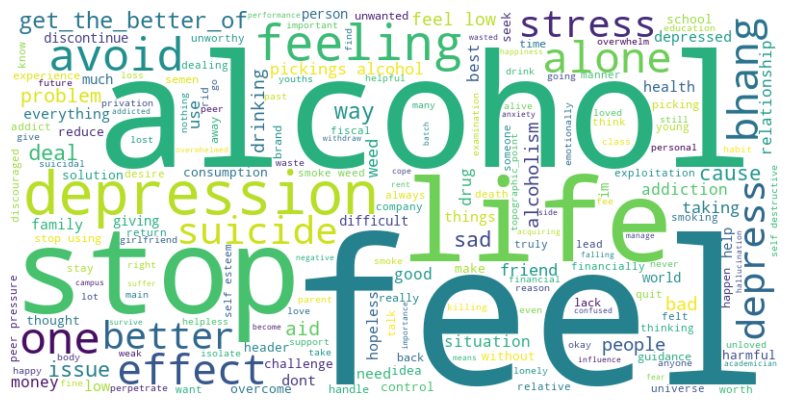

In [7]:
# Convert the column into a single string
train_text = " ".join(train_df['clean_text'].astype(str))

# Generate the word cloud in the train data
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(train_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()

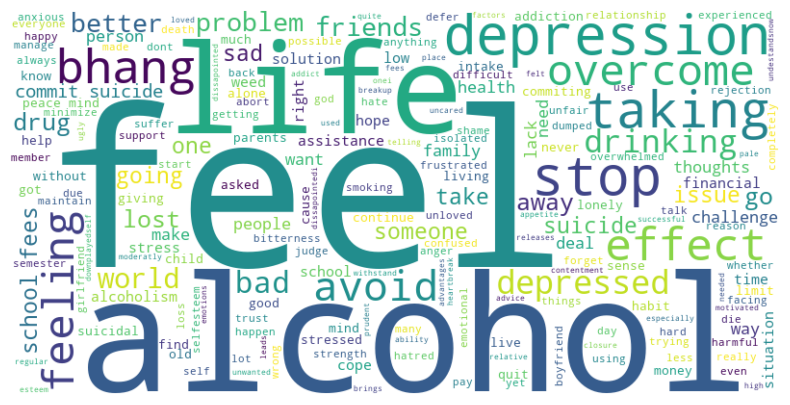

In [8]:
# Convert the column into a single string
test_text = " ".join(test_df['clean_text'].astype(str))

# Generate the word cloud in the test data
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(test_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.show()

C:\Users\Esther\AppData\Local\Temp\ipykernel_13768\968798212.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_df, palette='viridis')


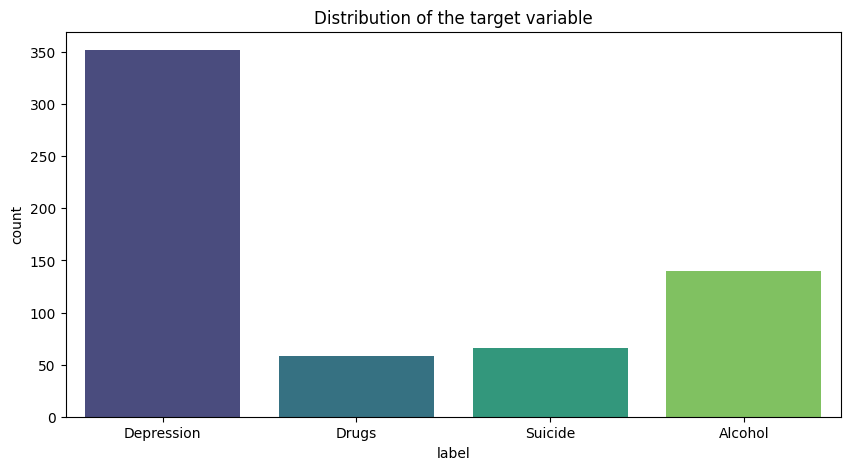

In [9]:
# Plot the distribution of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=train_df, palette='viridis')
plt.title('Distribution of the target variable')
plt.show()

In [10]:
# Get the max length for padding and truncation
max_length = train_df['clean_text'].apply(lambda x: len(str(x).split())).max()
print("Max length of cleaned text:", max_length)


Max length of cleaned text: 17


In [11]:
# Define max words (vocab size)
max_words = 1000  # Adjust based on dataset size

# Initialize tokenizer with vocabulary limit and OOV token
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")  

# Fit tokenizer on the cleaned text
tokenizer.fit_on_texts(train_df['clean_text'])

# Get actual vocabulary size (should be <= max_words)
vocab_size = min(max_words, len(tokenizer.word_index) + 1)  # +1 for OOV token
print("Vocabulary size:", vocab_size)

Vocabulary size: 785


In [12]:
# Convert text to sequences
X_train = tokenizer.texts_to_sequences(train_df["clean_text"])
X_test = tokenizer.texts_to_sequences(test_df["clean_text"])

# Padding the sequences
max_len = max_length  # Maximum sequence length
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding="post", truncating="post" )
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding="post", truncating="post")

print("Tokenized & Padded shape:", X_train_padded.shape, X_test_padded.shape)  # (num_samples, max_length)

# Display processed data samples
train_df[["text", "clean_text"]].head()

Tokenized & Padded shape: (616, 17) (309, 17)


,text,clean_text
0,I feel that it was better I dieAm happy,feel better dieam happy
1,Why do I get hallucinations?,get hallucination
2,I am stresseed due to lack of financial suppor...,stresseed due lack fiscal support school
3,Why is life important?,life important
4,How could I be helped to go through the depres...,could help go depression


In [13]:
# Encode the target variable labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["label"])

# One-hot encode labels for categorical classification
y_train = to_categorical(train_labels_encoded)

# Display label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
label_mapping


{'Alcohol': np.int64(0),
 'Depression': np.int64(1),
 'Drugs': np.int64(2),
 'Suicide': np.int64(3)}

## Modelling
### 1. Long Short Term Memory (LSTM)

In [14]:
# Define model parameters
embedding_dim = 128  # Size of word embeddings
lstm_units = 128  # Number of LSTM units
num_classes = len(label_mapping)  
input_length = max_length

# Define LSTM model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),  # Dropout applied to embeddings
    
    # First LSTM layer
    LSTM(128, return_sequences=True, activation="tanh", kernel_regularizer=l2(0.01)),  
    LayerNormalization(),  # Normalization for better stability

    # Second LSTM layer
    LSTM(64, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01)),  
    
    # Fully Connected Layer
    Dense(64, activation="relu", kernel_regularizer=l2(0.01)),  
    Dropout(0.5),  # Increased dropout for better regularization

    # Output Layer (for multiclass classification)
    Dense(num_classes, activation="softmax")
])

# Compile the model
model_lstm.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0003, decay=1e-6),  # Adaptive learning rate decay),
              metrics=['accuracy'])

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_df['label'].map(label_mapping)),  # Ensure correct labels
                                     y=train_df['label'].map(label_mapping))  # Your training labels

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

model_lstm.build(input_shape=(None, max_len))

# Model summary
model_lstm.summary()


c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 17, 128)        │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 17, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 17, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 17, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,148 (1.09 MB)

 Trainable params: 286,148 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

### LSTM Model Architecture

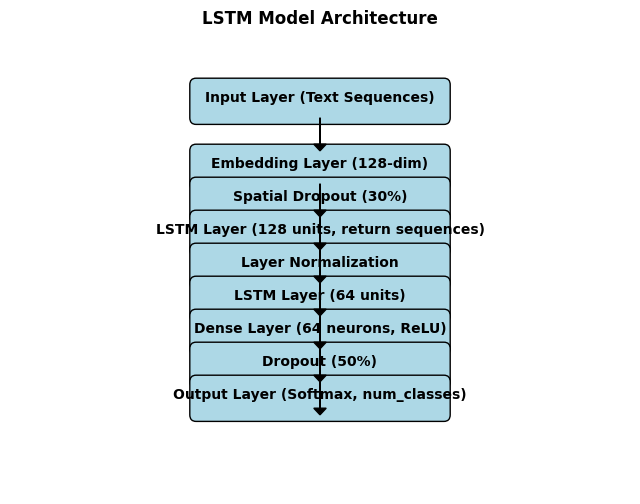

In [15]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.axis("off")

# Define layer positions
layers = [
    ("Input Layer (Text Sequences)", (5, 6)),
    ("Embedding Layer (128-dim)", (5, 5)),
    ("Spatial Dropout (30%)", (5, 4.5)),
    ("LSTM Layer (128 units, return sequences)", (5, 4)),
    ("Layer Normalization", (5, 3.5)),
    ("LSTM Layer (64 units)", (5, 3)),
    ("Dense Layer (64 neurons, ReLU)", (5, 2.5)),
    ("Dropout (50%)", (5, 2)),
    ("Output Layer (Softmax, num_classes)", (5, 1.5))
]

# Draw rectangles for each layer
for layer_name, (x, y) in layers:
    rect = mpatches.FancyBboxPatch((x - 2, y - 0.3), 4, 0.5, boxstyle="round,pad=0.1",
                                   edgecolor="black", facecolor="lightblue")
    ax.add_patch(rect)
    ax.text(x, y, layer_name, ha="center", va="center", fontsize=10, fontweight="bold")

# Draw arrows
for i in range(len(layers) - 1):
    ax.arrow(5, layers[i][1][1] - 0.3, 0, -0.4, head_width=0.2, head_length=0.1, fc="black", ec="black")

# Show the diagram
plt.title("LSTM Model Architecture", fontsize=12, fontweight="bold")
plt.show()


In [16]:
# Fit and train the model

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train model
history = model_lstm.fit(X_train_padded, y_train,
                    epochs=15, batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, lr_reduction])

# Save the trained model
#model_lstm.save("lstm_model.keras")


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.2398 - loss: 5.7059 - val_accuracy: 0.5161 - val_loss: 5.3949 - learning_rate: 3.0000e-04
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3193 - loss: 5.3207 - val_accuracy: 0.5242 - val_loss: 5.0691 - learning_rate: 3.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.2678 - loss: 5.0273 - val_accuracy: 0.1129 - val_loss: 4.8316 - learning_rate: 3.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.2214 - loss: 4.7019 - val_accuracy: 0.5242 - val_loss: 4.4762 - learning_rate: 3.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4161 - loss: 4.3663 - val_accuracy: 0.5242 - val_loss: 4.2300 - learning_rate: 3.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3468 - loss: 4.2005 - val_accuracy: 0.6774 - val_loss: 4.0097 - learning_rate: 3.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.449

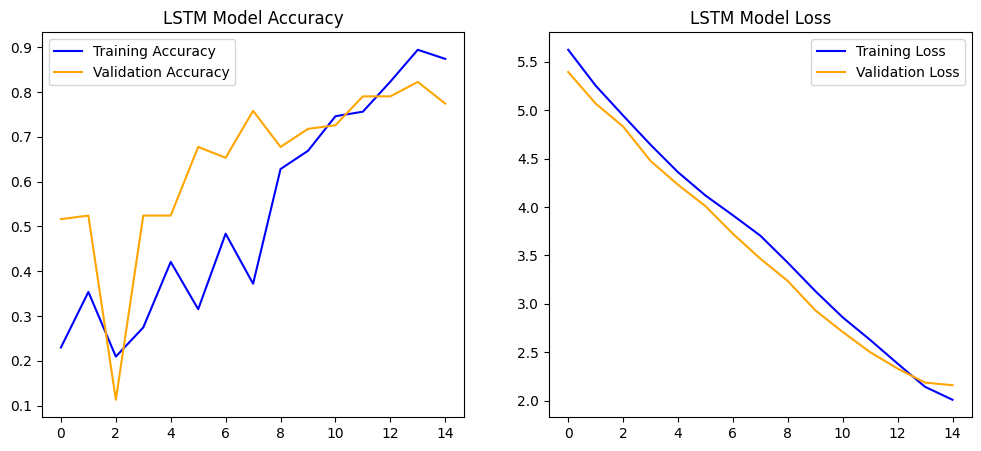

In [17]:
# visualize the training history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax[0].legend()
ax[0].set_title('LSTM Model Accuracy')

# Plot Loss
ax[1].plot(history.history['loss'], label='Training Loss', color='blue')
ax[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax[1].legend()
ax[1].set_title('LSTM Model Loss')

# Show the plots
plt.show()


### 2. Gated Recurrent  Unit (GRU)

In [18]:
# Define GRU model with enhancements
model_gru = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length),
    SpatialDropout1D(0.4),  # Dropout applied to word embeddings
    Bidirectional(GRU(128, return_sequences=True, activation="relu", kernel_regularizer=l2(0.01))),  # First BiGRU layer
    LayerNormalization(),  # Normalize activations to improve stability
    Bidirectional(GRU(64, activation="relu", kernel_regularizer=l2(0.01))),  # Second BiGRU layer
    Dense(64, activation="relu", kernel_regularizer=l2(0.01)),  # Fully connected layer with L2 regularization
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(num_classes, activation="softmax")  # Output layer
    ])
    
model_gru.compile(loss="categorical_crossentropy",
            optimizer=Adam(learning_rate=0.0003, decay=1e-6),  # Adaptive learning rate decay
            metrics=["accuracy"])

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_df['label'].map(label_mapping)),  # Ensure correct labels
                                     y=train_df['label'].map(label_mapping))  # Your training labels

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Build the GRU model
model_gru.build(input_shape=(None, max_length))  

# Show model summary
model_gru.summary()

c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 17, 128)        │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 17, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 17, 256)        │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 17, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 431,300 (1.65 MB)

 Trainable params: 431,300 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

### GRU Model Architecture

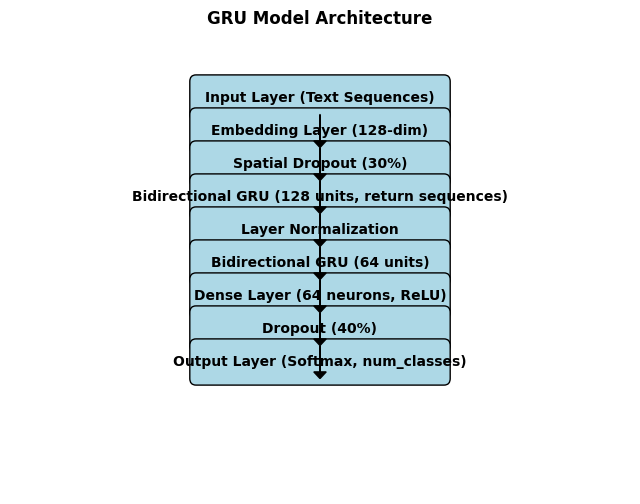

In [19]:
# Create figure
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.axis("off")

# Define layer positions
layers = [
    ("Input Layer (Text Sequences)", (5, 6)),
    ("Embedding Layer (128-dim)", (5, 5.5)),
    ("Spatial Dropout (30%)", (5, 5)),
    ("Bidirectional GRU (128 units, return sequences)", (5, 4.5)),
    ("Layer Normalization", (5, 4)),
    ("Bidirectional GRU (64 units)", (5, 3.5)),
    ("Dense Layer (64 neurons, ReLU)", (5, 3)),
    ("Dropout (40%)", (5, 2.5)),
    ("Output Layer (Softmax, num_classes)", (5, 2))
]

# Draw rectangles for each layer
for layer_name, (x, y) in layers:
    rect = mpatches.FancyBboxPatch((x - 2, y - 0.25), 4, 0.5, boxstyle="round,pad=0.1",
                                   edgecolor="black", facecolor="lightblue")
    ax.add_patch(rect)
    ax.text(x, y, layer_name, ha="center", va="center", fontsize=10, fontweight="bold")

# Draw arrows connecting the layers
for i in range(len(layers) - 1):
    ax.arrow(5, layers[i][1][1] - 0.25, 0, -0.4, head_width=0.2, head_length=0.1, fc="black", ec="black")

# Show the diagram
plt.title("GRU Model Architecture", fontsize=12, fontweight="bold")
plt.show()


In [20]:
# Fit and train the model

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train model
history = model_gru.fit(X_train_padded, y_train,
                    epochs=15, batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, lr_reduction])

# Save the trained model
#model_gru.save("gru_model.keras")

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.3513 - loss: 10.3108 - val_accuracy: 0.5484 - val_loss: 9.6220 - learning_rate: 3.0000e-04
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.4005 - loss: 9.4524 - val_accuracy: 0.6048 - val_loss: 8.8200 - learning_rate: 3.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5020 - loss: 8.6679 - val_accuracy: 0.6532 - val_loss: 8.0774 - learning_rate: 3.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5736 - loss: 7.9894 - val_accuracy: 0.7419 - val_loss: 7.3699 - learning_rate: 3.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6380 - loss: 7.2998 - val_accuracy: 0.7097 - val_loss: 6.7294 - learning_rate: 3.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.6443 - loss: 6.6395 - val_accuracy: 0.7177 - val_loss: 6.1480 - learning_rate: 3.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.74

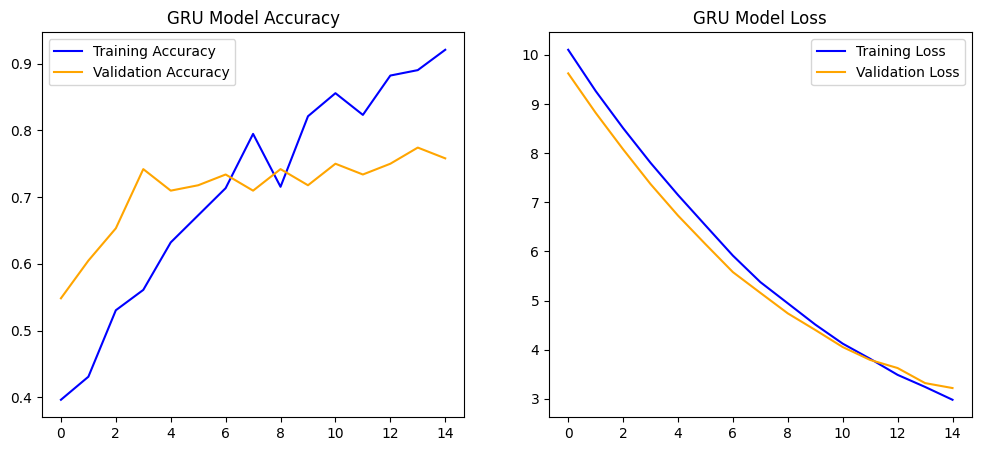

In [21]:
# visualize the training history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax[0].legend()
ax[0].set_title('GRU Model Accuracy')

# Plot Loss
ax[1].plot(history.history['loss'], label='Training Loss', color='blue')
ax[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax[1].legend()
ax[1].set_title('GRU Model Loss')

# Show the plots
plt.show()


### 3. Bidirectional LSTM

In [22]:
# Define model parameters
embedding_dim = 128  # Size of word embeddings
lstm_units = 128  # Number of LSTM units
num_classes = len(label_mapping)
input_length = max_length

# Define model
model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),  # Drop entire word embeddings with 30% probability
    Bidirectional(LSTM(128, return_sequences=True, activation="relu", kernel_regularizer=l2(0.01))),  # First BiLSTM with L2
    LayerNormalization(),  # Normalization for stable training
    Bidirectional(LSTM(64, activation="relu", kernel_regularizer=l2(0.01))),  # Second BiLSTM
    Dense(64, activation="relu", kernel_regularizer=l2(0.01)),  # Fully connected layer with L2 regularization
    Dropout(0.4),  # Dropout to prevent overfitting
    Dense(num_classes, activation="softmax")  # Output layer for multiclass classification
])

# Compile the model with an adaptive learning rate
model_bilstm.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0003),
    metrics=['accuracy']
)

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_df['label'].map(label_mapping)),  # Ensure correct labels
                                     y=train_df['label'].map(label_mapping))  # Your training labels

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Build the BiLSTM model
model_bilstm.build(input_shape=(None, max_length))

# Show model summary
model_bilstm.summary()


c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 17, 128)        │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ (None, 17, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 17, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 17, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537,028 (2.05 MB)

 Trainable params: 537,028 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

### BiLSTM Model Architecture

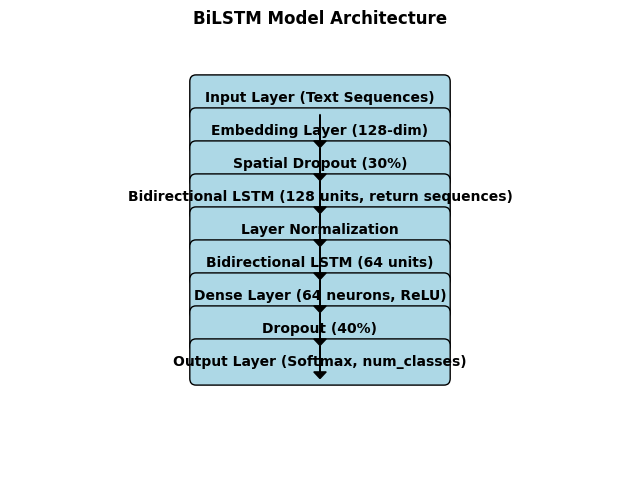

In [23]:
# Create figure for BiLSTM model architecture
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.axis("off")

# Define BiLSTM layer positions
bilstm_layers = [
    ("Input Layer (Text Sequences)", (5, 6)),
    ("Embedding Layer (128-dim)", (5, 5.5)),
    ("Spatial Dropout (30%)", (5, 5)),
    ("Bidirectional LSTM (128 units, return sequences)", (5, 4.5)),
    ("Layer Normalization", (5, 4)),
    ("Bidirectional LSTM (64 units)", (5, 3.5)),
    ("Dense Layer (64 neurons, ReLU)", (5, 3)),
    ("Dropout (40%)", (5, 2.5)),
    ("Output Layer (Softmax, num_classes)", (5, 2))
]

# Draw rectangles for each layer
for layer_name, (x, y) in bilstm_layers:
    rect = mpatches.FancyBboxPatch((x - 2, y - 0.25), 4, 0.5, boxstyle="round,pad=0.1",
                                   edgecolor="black", facecolor="lightblue")
    ax.add_patch(rect)
    ax.text(x, y, layer_name, ha="center", va="center", fontsize=10, fontweight="bold")

# Draw arrows connecting the layers
for i in range(len(bilstm_layers) - 1):
    ax.arrow(5, bilstm_layers[i][1][1] - 0.25, 0, -0.4, head_width=0.2, head_length=0.1, fc="black", ec="black")

# Show the diagram
plt.title("BiLSTM Model Architecture", fontsize=12, fontweight="bold")
plt.show()


In [24]:
# Fit and train the model

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train model
history = model_bilstm.fit(X_train_padded, y_train,
                    epochs=15, batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, lr_reduction])

# Save the trained model
#model_bilstm.save("bilstm_model.keras")

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 0.4098 - loss: 11.1373 - val_accuracy: 0.2097 - val_loss: 10.3672 - learning_rate: 3.0000e-04
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2871 - loss: 10.0459 - val_accuracy: 0.4274 - val_loss: 9.3263 - learning_rate: 3.0000e-04
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.4384 - loss: 9.0888 - val_accuracy: 0.6371 - val_loss: 8.3964 - learning_rate: 3.0000e-04
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.4889 - loss: 8.2157 - val_accuracy: 0.6290 - val_loss: 7.6183 - learning_rate: 3.0000e-04
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5239 - loss: 7.4732 - val_accuracy: 0.7097 - val_loss: 6.7673 - learning_rate: 3.0000e-04
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6653 - loss: 6.6482 - val_accuracy: 0.7258 - val_loss: 6.0120 - learning_rate: 3.0000e-04
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.

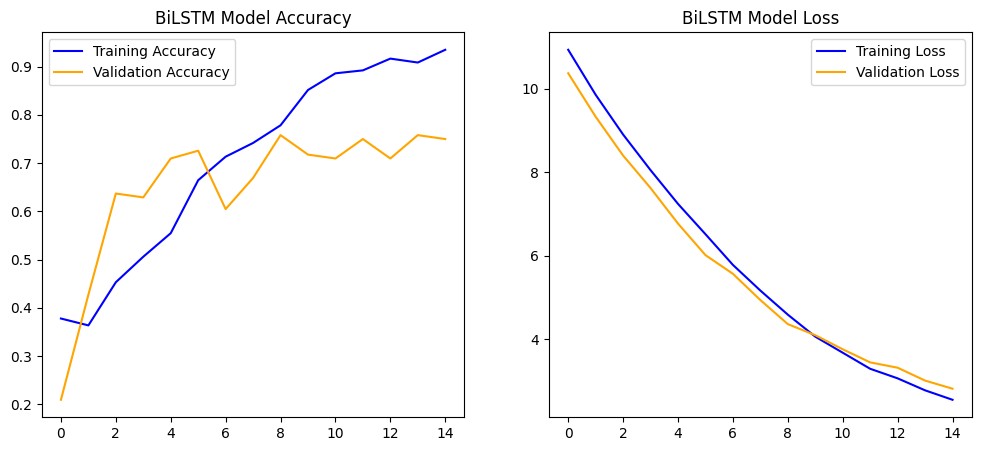

In [25]:
# Visualize the training history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax[0].legend()
ax[0].set_title('BiLSTM Model Accuracy')

# Plot Loss
ax[1].plot(history.history['loss'], label='Training Loss', color='blue')
ax[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax[1].legend()
ax[1].set_title('BiLSTM Model Loss')

# Show the plots
plt.show()

### 4. BiLSTM and GRU

In [26]:
# Define the Hybrid LSTM-GRU model
model_hybrid = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),  # Dropout applied to embeddings

    # First Bidirectional LSTM Layer
    Bidirectional(LSTM(128, return_sequences=True, activation="tanh", kernel_regularizer=l2(0.01))),  
    LayerNormalization(),  # Normalization for better training stability

    # Second Bidirectional GRU Layer
    Bidirectional(GRU(64, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01))),
    
    # Fully Connected Layer
    Dense(64, activation="relu", kernel_regularizer=l2(0.01)),  
    Dropout(0.5),  # Increased dropout for regularization

    # Output Layer (for multiclass classification)
    Dense(num_classes, activation="softmax")
])

# Compile the model
model_hybrid.compile(loss="categorical_crossentropy", 
                     optimizer=Adam(learning_rate=0.001), 
                     metrics=["accuracy"])

class_weights = compute_class_weight(class_weight="balanced",
                                     classes=np.unique(train_df['label'].map(label_mapping)),  # Ensure correct labels
                                     y=train_df['label'].map(label_mapping))  # Your training labels

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Build model
model_hybrid.build(input_shape=(None, max_length))

# Model summary
model_hybrid.summary()



c:\Users\Esther\miniconda3\envs\tf_env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 17, 128)        │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 17, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 17, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 17, 256)        │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 496,324 (1.89 MB)

 Trainable params: 496,324 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

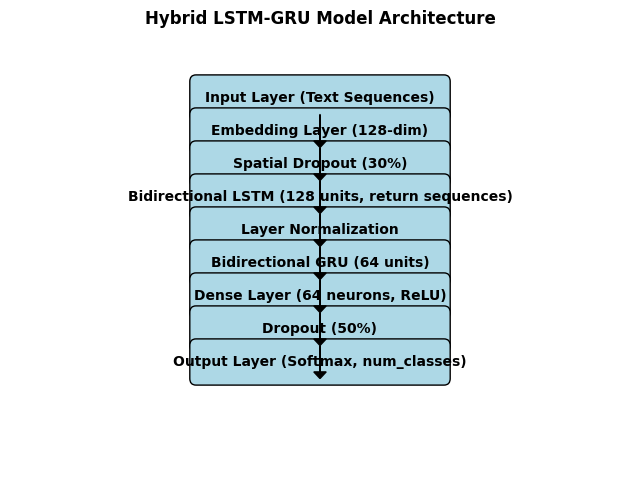

In [27]:
# Create figure for Hybrid LSTM-GRU model architecture 
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 7)
ax.axis("off")

# Define Hybrid LSTM-GRU layer positions
hybrid_layers = [
    ("Input Layer (Text Sequences)", (5, 6)),
    ("Embedding Layer (128-dim)", (5, 5.5)),
    ("Spatial Dropout (30%)", (5, 5)),
    ("Bidirectional LSTM (128 units, return sequences)", (5, 4.5)),
    ("Layer Normalization", (5, 4)),
    ("Bidirectional GRU (64 units)", (5, 3.5)),
    ("Dense Layer (64 neurons, ReLU)", (5, 3)),
    ("Dropout (50%)", (5, 2.5)),
    ("Output Layer (Softmax, num_classes)", (5, 2))
]

# Draw rectangles for each layer
for layer_name, (x, y) in hybrid_layers:
    rect = mpatches.FancyBboxPatch((x - 2, y - 0.25), 4, 0.5, boxstyle="round,pad=0.1",
                                   edgecolor="black", facecolor="lightblue")
    ax.add_patch(rect)
    ax.text(x, y, layer_name, ha="center", va="center", fontsize=10, fontweight="bold")

# Draw arrows connecting the layers
for i in range(len(hybrid_layers) - 1):
    ax.arrow(5, hybrid_layers[i][1][1] - 0.25, 0, -0.4, head_width=0.2, head_length=0.1, fc="black", ec="black")

# Show the diagram
plt.title("Hybrid LSTM-GRU Model Architecture", fontsize=12, fontweight="bold")
plt.show()


In [28]:
# Fit and train the model

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train model
history = model_hybrid.fit(X_train_padded, y_train,
                    epochs=15, batch_size=32,
                    validation_split=0.2,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, lr_scheduler])

# Save the trained model
#model_hybrid.save("model_hybrid.keras")

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.2357 - loss: 10.0030 - val_accuracy: 0.1290 - val_loss: 8.1262 - learning_rate: 0.0010
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.2441 - loss: 7.5093 - val_accuracy: 0.6048 - val_loss: 5.9991 - learning_rate: 0.0010
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4849 - loss: 5.5523 - val_accuracy: 0.5968 - val_loss: 4.5469 - learning_rate: 0.0010
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6295 - loss: 4.2654 - val_accuracy: 0.7419 - val_loss: 3.5499 - learning_rate: 0.0010
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7117 - loss: 3.2228 - val_accuracy: 0.7742 - val_loss: 2.8044 - learning_rate: 0.0010
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.7972 - loss: 2.6210 - val_accuracy: 0.7016 - val_loss: 2.4889 - learning_rate: 0.0010
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.8738 - loss: 2.1163 - val_

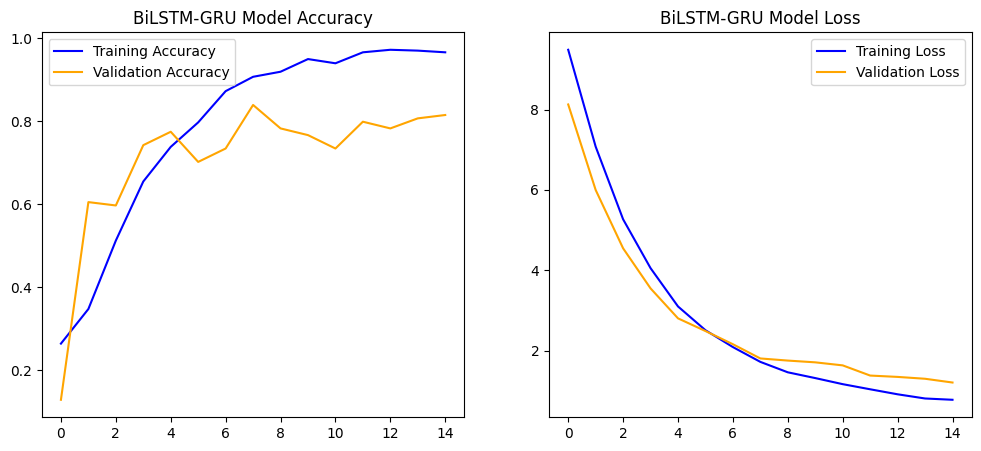

In [29]:
# Visualize the training history
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Accuracy
ax[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax[0].legend()
ax[0].set_title('BiLSTM-GRU Model Accuracy')

# Plot Loss
ax[1].plot(history.history['loss'], label='Training Loss', color='blue')
ax[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax[1].legend()
ax[1].set_title('BiLSTM-GRU Model Loss')

# Show the plots
plt.show()


## Evaluation of the models

In [30]:
# Compare the four models
print(f'lstm model loss and accuracy:{model_lstm.evaluate(X_train_padded, y_train)}')
print(f'bilstm model loss and accuracy:{model_bilstm.evaluate(X_train_padded, y_train)}')
print(f'gru model loss and accuracy:{model_gru.evaluate(X_train_padded, y_train)}')
print(f'hybrid model loss and accuracy:{model_hybrid.evaluate(X_train_padded, y_train)}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9024 - loss: 1.8727
lstm model loss and accuracy:[1.9270738363265991, 0.8814935088157654]
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9526 - loss: 2.3735
bilstm model loss and accuracy:[2.449007034301758, 0.9172077775001526]
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9499 - loss: 2.7607
gru model loss and accuracy:[2.8512096405029297, 0.9107142686843872]
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9778 - loss: 0.6695
hybrid model loss and accuracy:[0.7678581476211548, 0.948051929473877]


- The hybrid model seems to perform better with an accuracy of 98% 

## Predictions

In [31]:
# Get raw predictions (probabilities)
y_pred_prob = model_hybrid.predict(X_test_padded)

# Convert probabilities to class labels
y_pred_labels = np.argmax(y_pred_prob, axis=1).flatten()

# Print predicted labels
print("Predicted class labels:", y_pred_labels)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step
Predicted class labels: [1 1 1 1 2 1 1 1 0 0 1 3 1 2 0 1 1 2 1 2 1 1 0 2 3 1 1 3 1 3 1 1 1 1 1 2 1
 3 1 2 1 1 0 1 0 1 3 1 1 1 1 1 1 1 0 1 1 3 1 0 0 0 1 2 1 1 3 1 3 1 1 1 2 2
 1 1 2 2 1 3 1 3 1 0 3 1 2 0 1 1 1 2 2 1 2 1 1 1 1 1 1 0 2 3 1 3 1 1 0 2 1
 1 1 3 3 0 3 0 1 3 3 1 1 3 0 1 1 0 1 1 0 0 1 1 1 1 3 2 2 1 1 3 0 1 1 3 1 3
 0 1 1 0 1 1 2 1 1 0 1 1 0 3 0 0 3 1 1 1 3 1 1 0 2 0 0 2 3 2 0 3 1 3 1 0 0
 3 1 0 3 2 1 1 1 1 1 1 1 2 3 1 0 0 1 3 1 0 1 0 1 3 1 0 1 2 2 1 0 0 1 1 1 3
 1 1 3 0 2 1 1 3 1 1 1 1 3 1 2 3 1 1 1 1 1 1 2 1 0 2 1 0 1 3 1 1 0 1 1 2 3
 2 1 1 1 1 3 0 0 2 1 1 1 2 0 1 0 1 1 1 1 1 1 1 2 3 0 1 3 0 0 1 3 1 1 2 0 3
 3 1 2 1 1 1 0 1 2 1 3 2 1]


In [32]:
# Reverse the dictionary: map integers to their corresponding class names
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Convert numerical predictions to class names
prediction_labels = [reverse_label_mapping[label] for label in y_pred_labels]

print("Predicted class names:", prediction_labels)


Predicted class names: ['Depression', 'Depression', 'Depression', 'Depression', 'Drugs', 'Depression', 'Depression', 'Depression', 'Alcohol', 'Alcohol', 'Depression', 'Suicide', 'Depression', 'Drugs', 'Alcohol', 'Depression', 'Depression', 'Drugs', 'Depression', 'Drugs', 'Depression', 'Depression', 'Alcohol', 'Drugs', 'Suicide', 'Depression', 'Depression', 'Suicide', 'Depression', 'Suicide', 'Depression', 'Depression', 'Depression', 'Depression', 'Depression', 'Drugs', 'Depression', 'Suicide', 'Depression', 'Drugs', 'Depression', 'Depression', 'Alcohol', 'Depression', 'Alcohol', 'Depression', 'Suicide', 'Depression', 'Depression', 'Depression', 'Depression', 'Depression', 'Depression', 'Depression', 'Alcohol', 'Depression', 'Depression', 'Suicide', 'Depression', 'Alcohol', 'Alcohol', 'Alcohol', 'Depression', 'Drugs', 'Depression', 'Depression', 'Suicide', 'Depression', 'Suicide', 'Depression', 'Depression', 'Depression', 'Drugs', 'Drugs', 'Depression', 'Depression', 'Drugs', 'Drugs', '

C:\Users\Esther\AppData\Local\Temp\ipykernel_13768\2350631747.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=prediction_labels, data=test_df, palette='viridis')


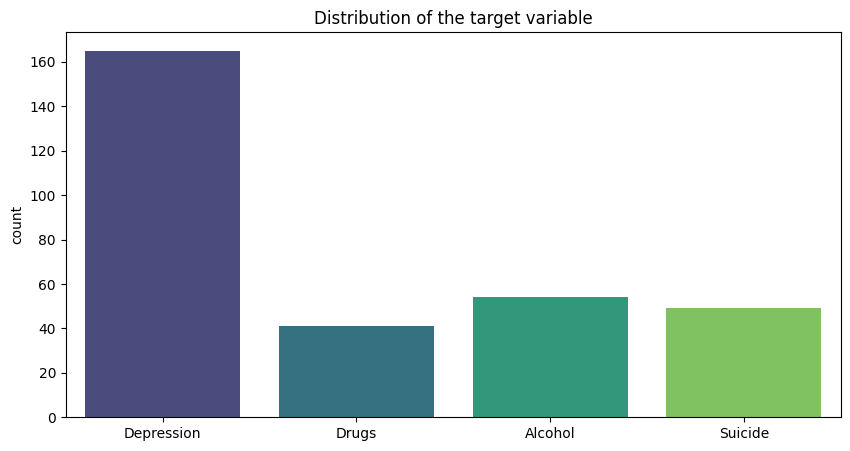

In [ ]:
# Plot the prediction labels
plt.figure(figsize=(10, 5))
sns.countplot(x=prediction_labels, data=test_df, palette='viridis')
plt.title('Distribution of the target variable')
plt.show()

In [34]:
# Save to CSV
results = pd.DataFrame({'text': test_df['text'],'predicted_label': prediction_labels})
results.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


C:\Users\Esther\AppData\Local\Temp\ipykernel_13768\2617326425.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(y_pred_labels, bins=len(label_mapping), kde=False, palette='viridis')


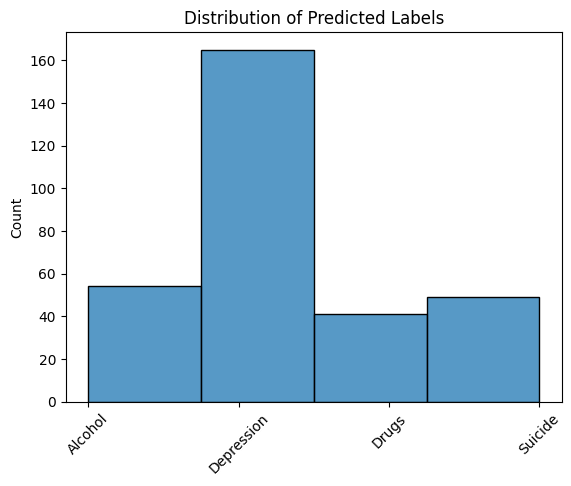

In [36]:
sns.histplot(y_pred_labels, bins=len(label_mapping), kde=False, palette='viridis')
plt.xticks(ticks=range(len(label_mapping)), labels=label_mapping.keys(), rotation=45)
plt.title("Distribution of Predicted Labels")
plt.show()